<a href="https://colab.research.google.com/github/dptru10/DenverXRay2022/blob/main/DenverXRay2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffraction simulation tutorial for the Denver X-ray Conference 2022, by Dennis Trujillo

In [1]:
import cv2
import numpy as np
from scipy import special 
from numpy.random import randint 
import matplotlib.pyplot as plt
from matplotlib import colors

## Generate simple real space shapes

We can easily generate squares with random sizes and positions via OpenCV

In [2]:
num_samples = 1000
img_size    = 256 

rec   = []
for i in range(num_samples): 
	vtx1 = randint(low=0,high=156)
	vty1 = vtx1 + 100
	
	vtx2 = randint(low=0,high=156)
	vty2 = vtx2 + 100

	img = np.zeros((img_size,img_size,3),np.uint8)
	rec.append(cv2.rectangle(img=img,pt1=(vtx1,vty1),\
    pt2=(vtx2,vty2),color=(255,255,255),thickness=-1))
 

Let's visualize some of the drawn squares...

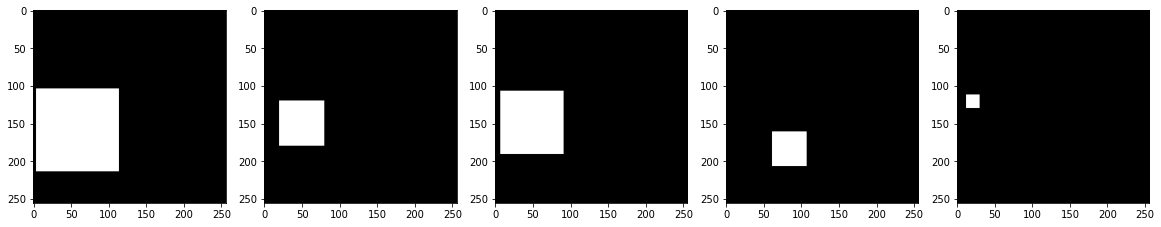

In [3]:
images = rec[10:15]
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    sub = fig.add_subplot(1, len(images), ii+1)
    image = images[ii]
    plt.imshow(image)

We can generate circles in the same way...

In [4]:
circ  = [] 
for i in range(num_samples):
  img = np.zeros((img_size,img_size,3),np.uint8)
  circ.append(cv2.circle(img=img,center=(randint(low=100,high=150),\
  randint(low=100,high=150)),radius=randint(low=1,high=100),\
  color=(255,255,255),thickness=-1))

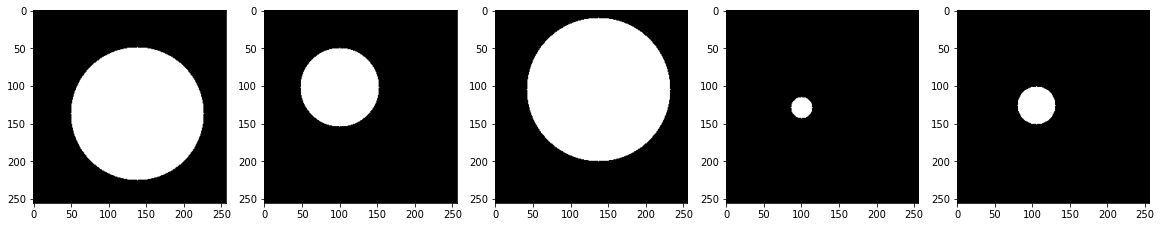

In [5]:
images = circ[:5]
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    sub = fig.add_subplot(1, len(images), ii+1)
    image = images[ii]
    plt.imshow(image)

# Generate a simulated gaussian beam to use as a probe

In [6]:
n  = 1  
L  = 1e-3                   #distance to detector (1 micron)
N  = 256                    #detector pixels (256 x 256)

dx = L/N                    #pixel size
x  = np.arange(-L/2,L/2,dx) 
y  = x 
X,Y= np.meshgrid(x,y) 
rho2 = np.power(X,2) + np.power(Y,2)
rho  = np.sqrt(rho2) 
phi  = np.arctan2(Y,X)

Here I'm generating a simple 256 x 256 gaussian beam with a wavelength of 633 nm 

In [7]:
r0      = 1e-3                               #curvature at z0                
wavelgth= 0.633e-6                           #wavelength HeNe 633 nm
k       = 2 * np.pi / wavelgth               #wavenumber 
kr      = 2.405 / r0
kz      = np.sqrt(np.power(k,2) - np.power(kr,2)) 
w0      = 0.5e-3                            #minimum radius spot size 500 micron
z       = (np.pi*np.power(w0,2)) / wavelgth #raleigh range (confocal parameter) 

Visualizing the real-space image of the probe...

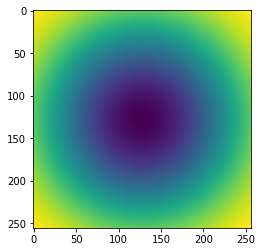

In [8]:
J  = special.jv(n,rho*kr)
U  = np.exp(-1j*kz*z)*J*np.exp(1j*n*phi)
I  = np.abs(U)**2 
probe = U
plt.figure() 
plt.imshow(I)
plt.show() 

In [9]:
def rgb2gray(rgb): 
	return np.dot(rgb[...,:3],[0.299,0.587,0.114])

# Make Diffraction Happen Cap'n

Here we simulate diffraction by taking the 2D-FFT of the product of the probe and object function

In [10]:
sq_frames = []
for square in rec:
  frame = np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(square)*probe)))**2 
  sq_frames.append(frame)

Visualizing the diffraction peaks generated with square objects...

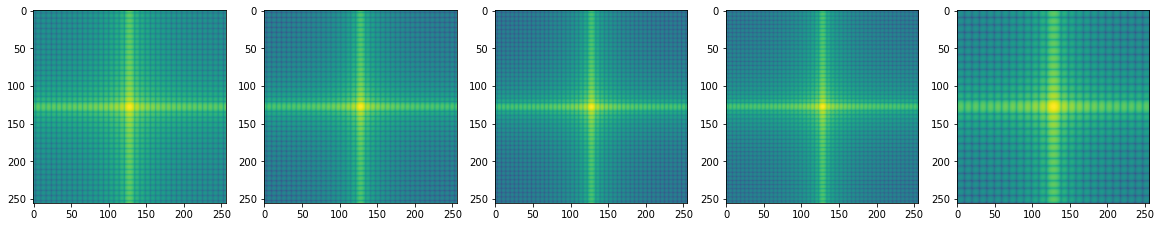

In [11]:
images = sq_frames[:5]
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    sub = fig.add_subplot(1, len(images), ii+1)
    image = images[ii]
    plt.imshow(image,norm=colors.LogNorm())

In [12]:
import os

square_path_train = 'diffraction_data/train/square'
if os.path.exists(square_path_train) is False: 
  os.makedirs(square_path_train)

i=0 
for ind_frame in sq_frames[:800]:
  plt.imsave("%s/square_%i.png" %(square_path_train,i), ind_frame)
  i+=1 


square_path_val = 'diffraction_data/val/square'
if os.path.exists(square_path_val) is False: 
  os.makedirs(square_path_val)

j=0
for ind_frame in sq_frames[801:]:
    plt.imsave("%s/square_%i.png" %(square_path_val,j), ind_frame)
    j+=1 

Similarly we can generate diffraction peaks for our circular objects as well

In [13]:
cr_frames = [] 
for circle in circ: 
  cr_frames.append(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(circle)*probe)))**2)

Visualizing the circular object function diffraction peaks

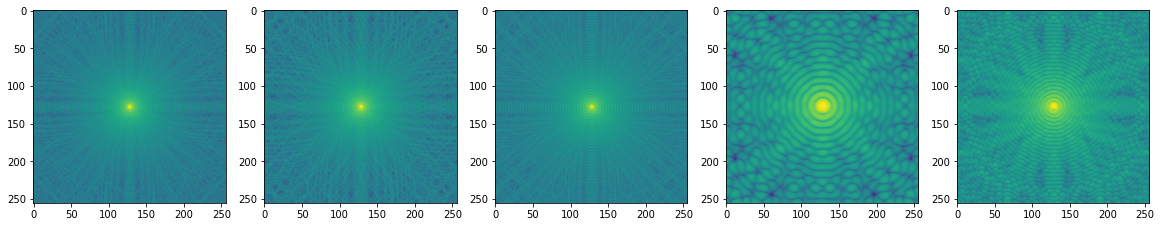

In [14]:
images = cr_frames[:5]
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    sub = fig.add_subplot(1, len(images), ii+1)
    image = images[ii]
    plt.imshow(image,norm=colors.LogNorm())

Saving the diffraction patterns as image files...

In [15]:
import os

circle_path_train = 'diffraction_data/train/circle'
if os.path.exists(circle_path_train) is False: 
  os.makedirs(circle_path_train)

i=0 
for ind_frame in cr_frames[:800]:
  plt.imsave("%s/circle_%i.png" %(circle_path_train,i), ind_frame)
  i+=1 


circle_path_val = 'diffraction_data/val/circle'
if os.path.exists(circle_path_val) is False: 
  os.makedirs(circle_path_val)

j=0
for ind_frame in cr_frames[801:]:
    plt.imsave("%s/square_%i.png" %(circle_path_val,j), ind_frame)
    j+=1 

# Pytorch Time...

In this portion of the tutorial I go over how to utilize an existing model ResNet18 as a starting point for training a CNN with experimental data 

In [16]:
from __future__ import print_function
import os
import time
import copy
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

Define some model parameters and whether we are utilizing pretrained weights...

In [17]:
show        = True 
pretrain    = False
data_dir    = 'diffraction_data'
batch_size  = 4            # Number of samples in each batch
num_workers = 2            
epoch_num   = 25           # Number of epochs to train the network
lr          = 1e-3         # Learning rate

Convert numpy arrays to tensor objects via a torchvision transform, many useful simple to employ transforms exist (see, https://pytorch.org/vision/stable/transforms.html) 

In [18]:
data_transforms = {
    'train': transforms.ToTensor(),
    'val': transforms.ToTensor()
}

Load images from directories and apply data transforms, create dataloaders for batchwise training...

In [19]:
data_dir = 'diffraction_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                  data_transforms[x])
                for x in ['train', 'val']}
#print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
              shuffle=True, num_workers=4)
              for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's check out dataset sizes...

In [20]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 1600, 'val': 398}


It's very simple to define the device on which we want to run our models, we can immediately utilze Nvidia GPU resources with this one line if they're available

In [21]:
class_names = image_datasets['train'].classes
inputs, classes = next(iter(dataloaders['train']))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


cuda


It's super easy to import a pretrained/defined model in pytorch as a starting point for a similar project, here we're using the ResNet18 model (https://arxiv.org/abs/1512.03385) if we use the pretrained weights we are implementing the model trained with ImageNet (< 1 million images)! 

In [22]:
model_ft = models.resnet18(pretrained=pretrain)
if torch.cuda.device_count() > 1: 
    print("Using ", torch.cuda.device_count(),"gpus!")
    model_ft = nn.DataParallel(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Other models exist in the pytorch research model repo, many of which are great starting points for exisiting problems in science, (https://pytorch.org/hub/research-models) 

In [37]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Let's define a few functions for visualizing data...

In [23]:
def imshow(inp, title=None, fname=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    if show is True: 
        plt.imshow(inp,norm=colors.LogNorm())
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    if fname is not None: 
        plt.savefig('%s' %fname)  

Visualizing a random set of training data...

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print('actual labels')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                #print(class_names[labels[j]]) 
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                fig.tight_layout() 
                ax.axis('off')
                ax.set_title('predicted: {}\nactual: {}' .format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j],fname='model_predict.jpg')
                


                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


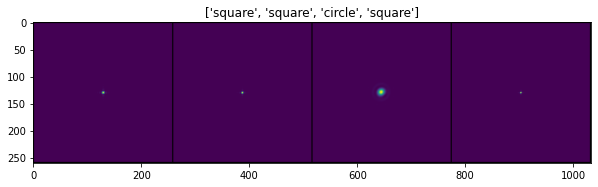

In [25]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Further let's define a training function to train and validate our model...

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('%s Epoch [%d]/[%d] running loss: %.6f Acc:%.6f' %
                      (phase, epoch + 1, num_epochs, running_loss/len(dataloaders[phase]),epoch_acc))
            running_loss = 0.0


            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

And so we finally train the model, we are utilizng CrossEntropy as the loss function (we could have used BCELoss, as well) and we utilize a scheduler to help manage when we adjust the learning rate...

In [27]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft=model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch_num)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Epoch [1]/[25] running loss: 1.624985 Acc:0.821250
val Epoch [1]/[25] running loss: 4.672539 Acc:0.535176

train Epoch [2]/[25] running loss: 0.968283 Acc:0.911875
val Epoch [2]/[25] running loss: 2.506783 Acc:0.798995

train Epoch [3]/[25] running loss: 0.777340 Acc:0.925625
val Epoch [3]/[25] running loss: 0.465211 Acc:0.962312

train Epoch [4]/[25] running loss: 0.305947 Acc:0.971250
val Epoch [4]/[25] running loss: 0.423046 Acc:0.982412

train Epoch [5]/[25] running loss: 0.325030 Acc:0.968125
val Epoch [5]/[25] running loss: 0.430009 Acc:0.979899

train Epoch [6]/[25] running loss: 0.260899 Acc:0.975000
val Epoch [6]/[25] running loss: 0.317920 Acc:0.974874

train Epoch [7]/[25] running loss: 0.161146 Acc:0.988125
val Epoch [7]/[25] running loss: 0.094349 Acc:0.989950

train Epoch [8]/[25] running loss: 0.049154 Acc:0.997500
val Epoch [8]/[25] running loss: 0.124447 Acc:0.984925

train Epoch [9]/[25] running loss: 0.062790 Acc:0.996250
val Epoch [9]/[25] running loss: 0.1430

Let's visualize a few predictions...

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


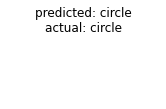

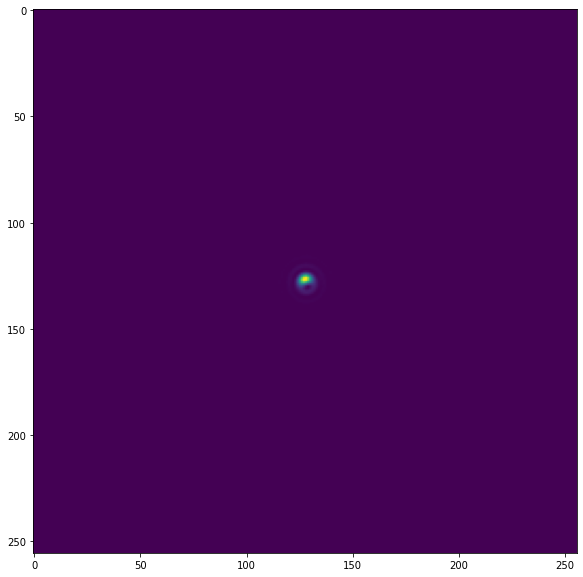

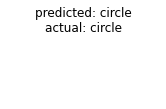

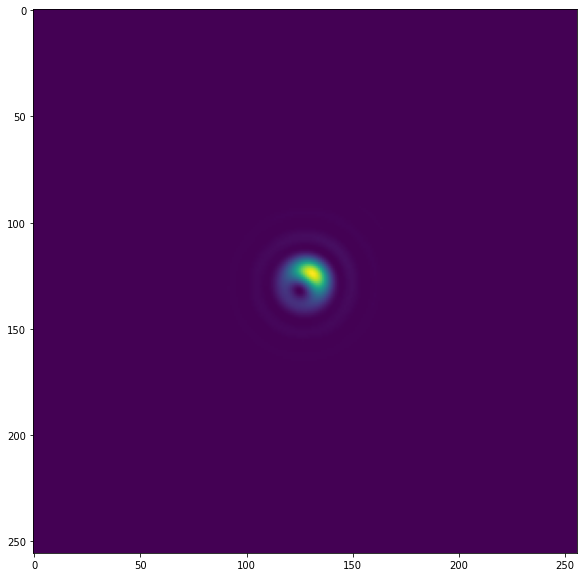

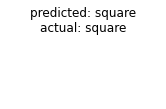

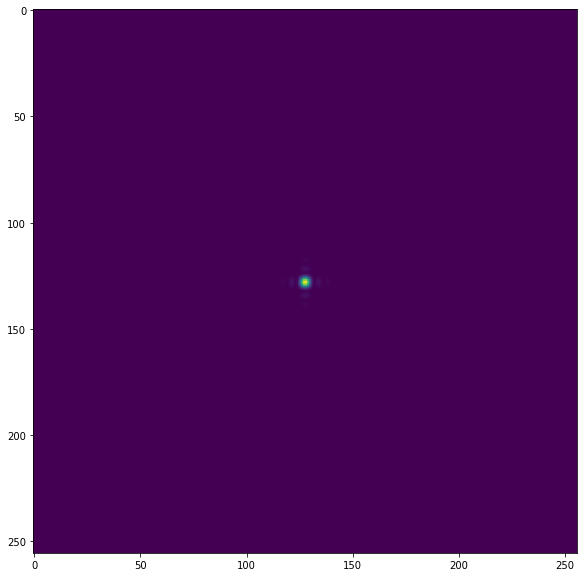

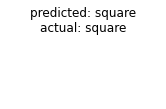

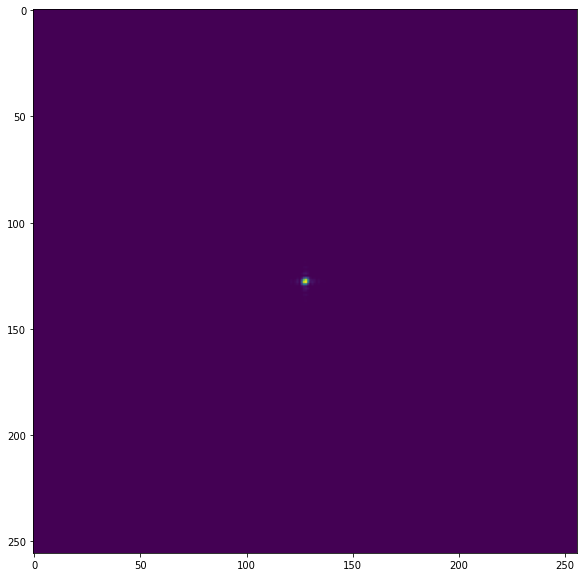

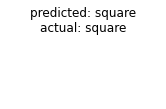

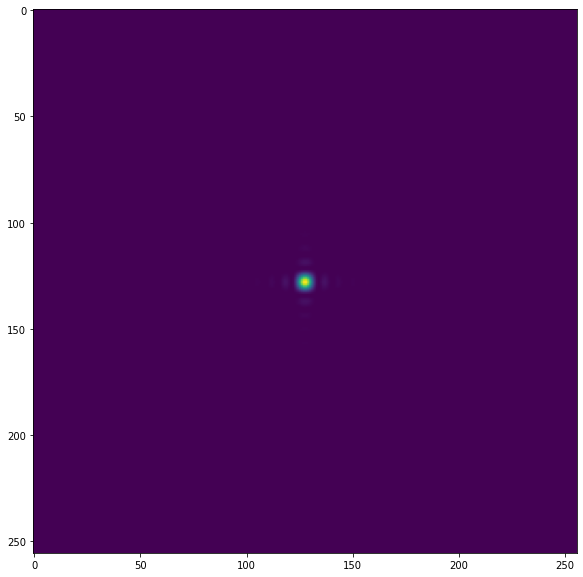

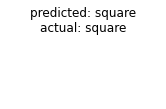

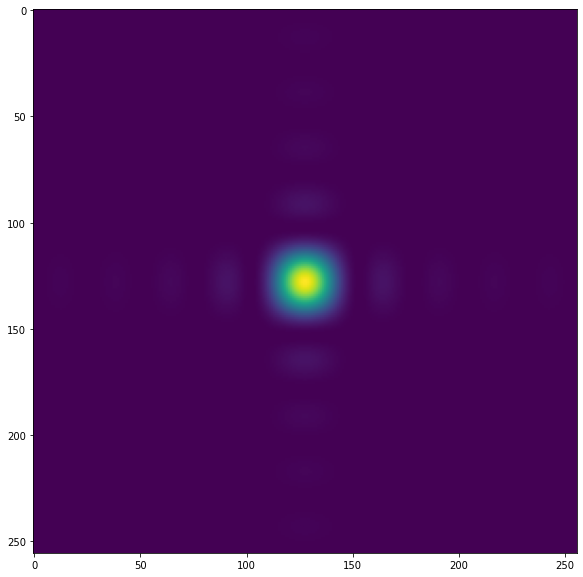

<Figure size 432x288 with 0 Axes>

In [28]:
if os.path.exists('models') is False: 
  os.mkdir('models')
  
filename = 'models/model.pth'
torch.save(model_ft.state_dict(), filename)

visualize_model(model_ft)

And finally visualize the performance of our model on the validation set via a confusion matrix...

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Text(0.5, 1.0, 'Confusion Matrix')

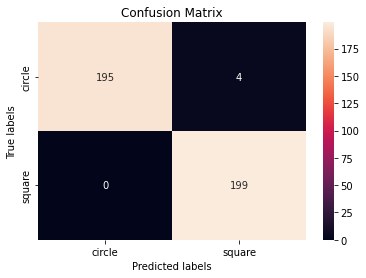

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import pandas as pd 

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
ax= plt.subplot()

class_names = ['circle', 'square']
sns.heatmap(conf_mat, annot=True, fmt='d')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_title('Confusion Matrix')

Lastly we can print out the per class accuracy

In [44]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_names)
print(class_accuracy)

['circle', 'square']
[ 97.98994975 100.        ]
